In [43]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import h5py 
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random
import copy
from scipy.io import savemat

## Load datasets
1. Load noisy datasets to train the mimmax_scaler
2. Load clean data to train MLPclean
3. Load noisy data to train MLPnoisy

In [44]:
all_snrs= np.arange(-20.0, 11, 5)
all_snrs= np.append(all_snrs, np.inf)
snr_training_weights= np.flip(len(all_snrs)-np.arange(len(all_snrs)))/len(all_snrs)
# snr_training_weights = np.ones(all_snrs.shape)
print(snr_training_weights)

root_data_dir= '../Datasets/CarModPow/PyData/'

# Load clean data 
train_test_dataset = h5py.File(root_data_dir + 'CarMod_data_clean.h5', "r")
data_x_clean_orig = np.array(train_test_dataset["data_CarMod_x"][:]) # your train set features
data_y_clean_orig = np.ravel(np.array(train_test_dataset["data_label_y"][:])) # your train set labels

print(f"pre-shape:data_x_clean_orig={data_x_clean_orig.shape}, data_y_clean_orig={data_y_clean_orig.shape}")
data_x_clean_orig = np.reshape(data_x_clean_orig,(data_x_clean_orig.shape[0],data_x_clean_orig.shape[1]*data_x_clean_orig.shape[2]))
print(f"post-shape:data_x_clean_orig={data_x_clean_orig.shape}, data_y_clean_orig={data_y_clean_orig.shape}")
# data_clean_fnames = np.ravel(np.array(train_test_dataset["data_filename"][:])) # your train set labels

train_inds, test_inds = train_test_split(np.arange(data_x_clean_orig.shape[0]), test_size=0.25, random_state=1)

all_train_x_orig = data_x_clean_orig[train_inds]
all_train_y_orig = data_y_clean_orig[train_inds]

# Load all SNR data 
for snr_value,snr_weight in zip(all_snrs[0:-1], snr_training_weights[0:-1]):
    print(f"SNR={snr_value} dB and weight = {snr_weight}")
    out_CarMod_data_file = root_data_dir + 'CarMod_data_SNR' + snr_value.astype('int').astype('str') + '.h5'    
    cur_dataset = h5py.File(out_CarMod_data_file, "r")
        
    cur_x = np.array(cur_dataset["data_CarMod_x"][:])
    cur_x = np.reshape(cur_x,(cur_x.shape[0],cur_x.shape[1]*cur_x.shape[2]))
    cur_y = np.ravel(np.array(cur_dataset["data_label_y"][:]))
    
    if snr_weight is 1:
        sample_inds_training, _= train_test_split(np.arange(len(train_inds)), test_size= 1-snr_weight, random_state=1)
    else:
        sample_inds_training = np.ones(train_inds.shape)==1


    all_train_x_orig = np.concatenate((all_train_x_orig, cur_x[train_inds[sample_inds_training]]))
    all_train_y_orig = np.concatenate((all_train_y_orig, cur_y[train_inds[sample_inds_training]]))
    print(f"shape:cur={cur_x.shape},cur_subsamp={len(sample_inds_training)}, full={len(train_inds)}, all_train_x_orig={all_train_x_orig.shape},type={type(cur_x)}")

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(all_train_x_orig)

train_clean_x_norm = minmax_scaler.transform(data_x_clean_orig)
all_train_x_norm = minmax_scaler.transform(all_train_x_orig)

X_train_clean, X_test_clean, y_train_clean, y_test_clean, train_inds, test_inds = train_test_split \
    (train_clean_x_norm, data_y_clean_orig, np.arange(train_clean_x_norm.shape[0]), test_size=0.25, random_state=1)
print(f"Type: X_train_clean={type(X_train_clean)}, y_train_clean={type(y_train_clean)}")
print(f"Shapes: X_train_clean={X_train_clean.shape}, y_train_clean={y_train_clean.shape}, X_test_clean={X_test_clean.shape}, y_test_clean={y_test_clean.shape}")

unq_vals, unq_counts = np.unique(y_train_clean, return_counts=True)
print(dict(zip(unq_vals,unq_counts))) 

[0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
pre-shape:data_x_clean_orig=(1605, 67, 9), data_y_clean_orig=(1605,)
post-shape:data_x_clean_orig=(1605, 603), data_y_clean_orig=(1605,)
SNR=-20.0 dB and weight = 0.125
shape:cur=(1605, 603),cur_subsamp=1203, full=1203, all_train_x_orig=(2406, 603),type=<class 'numpy.ndarray'>
SNR=-15.0 dB and weight = 0.25
shape:cur=(1605, 603),cur_subsamp=1203, full=1203, all_train_x_orig=(3609, 603),type=<class 'numpy.ndarray'>
SNR=-10.0 dB and weight = 0.375
shape:cur=(1605, 603),cur_subsamp=1203, full=1203, all_train_x_orig=(4812, 603),type=<class 'numpy.ndarray'>
SNR=-5.0 dB and weight = 0.5
shape:cur=(1605, 603),cur_subsamp=1203, full=1203, all_train_x_orig=(6015, 603),type=<class 'numpy.ndarray'>
SNR=0.0 dB and weight = 0.625
shape:cur=(1605, 603),cur_subsamp=1203, full=1203, all_train_x_orig=(7218, 603),type=<class 'numpy.ndarray'>
SNR=5.0 dB and weight = 0.75
shape:cur=(1605, 603),cur_subsamp=1203, full=1203, all_train_x_orig=(8421, 603),type=

## Model #1: An SVM model (rbf kernels seem to work the best)

Unique values in y_test_pred=[0 1 2 3 4]
Unique values in y_train_clean=[0 1 2 3 4]
Training accuracy=0.9875311720698254
 Testing accuracy=0.9701492537313433



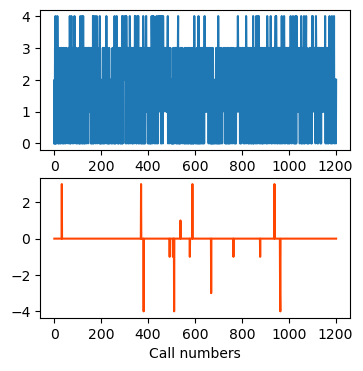

In [45]:
svm_model = svm.SVC(kernel='rbf').fit(X_train_clean, y_train_clean)
y_train_pred = svm_model.predict(X_train_clean)
y_test_pred = svm_model.predict(X_test_clean)

print(f"Unique values in y_test_pred={np.unique(y_test_pred)}")
print(f"Unique values in y_train_clean={np.unique(y_train_clean)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_clean)
ax[1].plot(y_train_clean-y_train_pred, color = "orangered")
ax[1].set_xlabel("Call numbers")

print(f"Training accuracy={np.sum(y_train_clean==y_train_pred)/len(y_train_pred)}\n Testing accuracy={np.sum(y_test_clean==y_test_pred)/len(y_test_pred)}\n")

## Model #2. Train an MLP on clean calls 

In [46]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
MLPclean = Sequential(
    [
        Dense(15, activation = 'relu',   name = "L1"),
        Dropout(0.2),
        Dense(5, activation = 'linear', name = "L2")
    ]
)

# Compile the model 
MLPclean.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy'],
)

# Fit the model 
MLPclean.fit(
    X_train_clean,y_train_clean,
    epochs=200
)

Train on 1203 samples
Epoch 1/200
1203/1203 [==============================] - 0s 238us/sample - loss: 0.8288 - accuracy: 0.6891
Epoch 2/200
1203/1203 [==============================] - 0s 33us/sample - loss: 0.3565 - accuracy: 0.8903
Epoch 3/200
1203/1203 [==============================] - 0s 28us/sample - loss: 0.2664 - accuracy: 0.9127
Epoch 4/200
1203/1203 [==============================] - 0s 29us/sample - loss: 0.2281 - accuracy: 0.9343
Epoch 5/200
1203/1203 [==============================] - 0s 29us/sample - loss: 0.2399 - accuracy: 0.9202
Epoch 6/200
1203/1203 [==============================] - 0s 28us/sample - loss: 0.2110 - accuracy: 0.9227
Epoch 7/200
1203/1203 [==============================] - 0s 28us/sample - loss: 0.2136 - accuracy: 0.9302
Epoch 8/200
1203/1203 [==============================] - 0s 27us/sample - loss: 0.1923 - accuracy: 0.9252
Epoch 9/200
1203/1203 [==============================] - 0s 33us/sample - loss: 0.1880 - accuracy: 0.9401
Epoch 10/200
1203/1203 

## Test MLP accuracy for training and testing 

Unique values in y_train_clean=[0 1 2 3 4]
Unique values in y_test_pred=[0 1 2 3 4]
Training accuracy=1.0
 Testing accuracy=0.9751243781094527



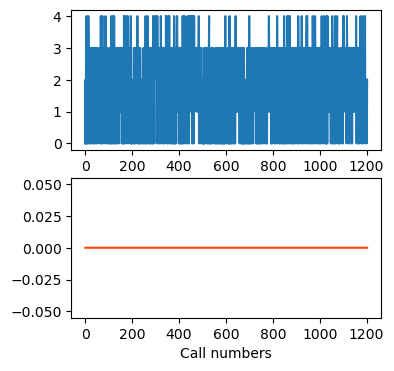

In [47]:
y_train_pred_NN = np.argmax(MLPclean.predict(X_train_clean), axis=1)
y_test_pred_NN = np.argmax(MLPclean.predict(X_test_clean), axis=1)

print(f"Unique values in y_train_clean={np.unique(y_train_pred_NN)}")
print(f"Unique values in y_test_pred={np.unique(y_test_pred_NN)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_clean)
ax[1].plot(y_train_clean-y_train_pred_NN, color = "orangered")
ax[1].set_xlabel("Call numbers")

train_accuracy_cleanMLP = np.sum(y_train_clean==y_train_pred_NN)/len(y_train_clean)
print(f"Training accuracy={train_accuracy_cleanMLP}\n Testing accuracy={np.sum(y_test_clean==y_test_pred_NN)/len(y_test_clean)}\n")

## Model #3. MLP cleaned on noisy calls 

In [48]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
MLPnoisy = Sequential(
    [
        Dense(20, activation = 'relu',   name = "L1"),
        Dense(5, activation = 'linear', name = "L2")
    ]
)

# Compile the model 
MLPnoisy.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy'],
)

# Fit the model 
MLPnoisy.fit(
    all_train_x_norm, all_train_y_orig,
    epochs=200,
)

Train on 9624 samples
Epoch 1/200
9624/9624 [==============================] - 0s 50us/sample - loss: 0.7700 - accuracy: 0.7063
Epoch 2/200
9624/9624 [==============================] - 0s 26us/sample - loss: 0.5102 - accuracy: 0.8130
Epoch 3/200
9624/9624 [==============================] - 0s 25us/sample - loss: 0.4637 - accuracy: 0.8339
Epoch 4/200
9624/9624 [==============================] - 0s 24us/sample - loss: 0.4194 - accuracy: 0.8455
Epoch 5/200
9624/9624 [==============================] - 0s 26us/sample - loss: 0.4028 - accuracy: 0.8546
Epoch 6/200
9624/9624 [==============================] - 0s 26us/sample - loss: 0.3869 - accuracy: 0.8569
Epoch 7/200
9624/9624 [==============================] - 0s 26us/sample - loss: 0.3717 - accuracy: 0.8642
Epoch 8/200
9624/9624 [==============================] - 0s 26us/sample - loss: 0.3616 - accuracy: 0.8670
Epoch 9/200
9624/9624 [==============================] - 0s 27us/sample - loss: 0.3550 - accuracy: 0.8687
Epoch 10/200
9624/9624 [

## Test in different SNRs 

In [49]:
def test_MLP_snr(MLPmodel, minmax_scaler, snr_value, test_inds_clean):
    root_out_dir= '../Datasets/CarModPow/PyData/'
    if np.isinf(snr_value):
        out_CarMod_data_file = root_data_dir + 'CarMod_data_clean.h5'
    else:
        out_CarMod_data_file = root_out_dir + 'CarMod_data_SNR' + snr_value.astype('int').astype('str') + '.h5'
    cur_snr_dataset = h5py.File(out_CarMod_data_file, "r")
    print(cur_snr_dataset)
    data_x_orig = np.array(cur_snr_dataset["data_CarMod_x"][:]) # your train set features
    data_x_orig= np.reshape(data_x_orig, (data_x_orig.shape[0],data_x_orig.shape[1]*data_x_orig.shape[2]))
    data_y_orig = np.ravel(np.array(cur_snr_dataset["data_label_y"][:])) # your train set labels
    # data_fnames = np.ravel(np.array(cur_snr_dataset["data_filename"][:])) # your train set labels
    data_x_norm = minmax_scaler.transform(data_x_orig)

    X_test = data_x_norm[test_inds]
    y_test = data_y_orig[test_inds]
    # fName_test= data_fnames[test_inds]
    
    # rand_int = random.randint(0, len(test_fnames_clean))
    # clean_name = test_fnames_clean[rand_int].decode("utf-8")
    # noisy_name= fName_test[rand_int].decode("utf-8")

    # print(f"fnumber={rand_int} |-| clean={clean_name}|noisy={noisy_name}")
    # clean_name= clean_name[clean_name.rfind('/')+1:-3]
    # noisy_name= noisy_name[noisy_name.rfind('/')+1:-3]
    # if clean_name!=noisy_name:
    #     print("Should be same")
    y_test_pred_NN = np.argmax(MLPmodel.predict(X_test), axis=1)
    accuracy = np.sum(y_test==y_test_pred_NN)/len(y_test_clean)
    print(f"[SNR={snr_value} dB] Accuracy={accuracy}\n")
    
    return accuracy

y_train_pred_NN = np.argmax(MLPnoisy.predict(all_train_x_norm), axis=1)
train_accuracy_noisyMLP = np.sum(all_train_y_orig==y_train_pred_NN)/len(all_train_y_orig)

test_accuracy_cleanMLP = np.zeros(all_snrs.shape)
test_accuracy_noisyMLP = np.zeros(all_snrs.shape)
for snr_value,iter in zip(all_snrs,range(len(all_snrs))):
    test_accuracy_cleanMLP[iter]= test_MLP_snr(MLPclean, minmax_scaler, snr_value, test_inds)
    test_accuracy_noisyMLP[iter]= test_MLP_snr(MLPnoisy, minmax_scaler, snr_value, test_inds)
    # print(f"SNR={snr_value} dB | Accuracy={test_accuracy[iter]}")

<HDF5 file "CarMod_data_SNR-20.h5" (mode r)>
[SNR=-20.0 dB] Accuracy=0.05223880597014925

<HDF5 file "CarMod_data_SNR-20.h5" (mode r)>
[SNR=-20.0 dB] Accuracy=0.48258706467661694

<HDF5 file "CarMod_data_SNR-15.h5" (mode r)>
[SNR=-15.0 dB] Accuracy=0.05970149253731343

<HDF5 file "CarMod_data_SNR-15.h5" (mode r)>
[SNR=-15.0 dB] Accuracy=0.7412935323383084

<HDF5 file "CarMod_data_SNR-10.h5" (mode r)>
[SNR=-10.0 dB] Accuracy=0.08955223880597014

<HDF5 file "CarMod_data_SNR-10.h5" (mode r)>
[SNR=-10.0 dB] Accuracy=0.8656716417910447

<HDF5 file "CarMod_data_SNR-5.h5" (mode r)>
[SNR=-5.0 dB] Accuracy=0.12437810945273632

<HDF5 file "CarMod_data_SNR-5.h5" (mode r)>
[SNR=-5.0 dB] Accuracy=0.9154228855721394

<HDF5 file "CarMod_data_SNR0.h5" (mode r)>
[SNR=0.0 dB] Accuracy=0.20398009950248755

<HDF5 file "CarMod_data_SNR0.h5" (mode r)>
[SNR=0.0 dB] Accuracy=0.927860696517413

<HDF5 file "CarMod_data_SNR5.h5" (mode r)>
[SNR=5.0 dB] Accuracy=0.6741293532338308

<HDF5 file "CarMod_data_SNR5.h5"

## Plot results 

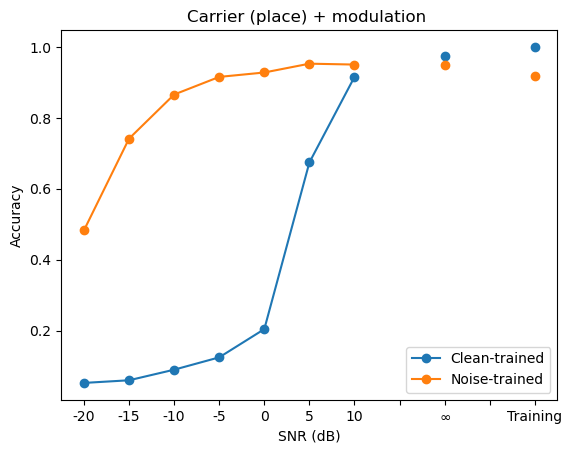

In [53]:
doSave = True
plot_snr= copy.deepcopy(all_snrs)
plot_snr[np.isinf(plot_snr)] = 20
plot_snr = np.append(plot_snr[:-1], [15, plot_snr[-1], 25, 30])
plot_snr_label = [str(item.astype('int')) for item in plot_snr[:-4]] + [''] + ['$\infty$'] + [''] + ['Training']
plt_accuracy_clean = np.append(test_accuracy_cleanMLP[:-1], [np.nan, test_accuracy_cleanMLP[-1], np.nan, train_accuracy_cleanMLP])
plt_accuracy_noisy = np.append(test_accuracy_noisyMLP[:-1], [np.nan, test_accuracy_noisyMLP[-1], np.nan, train_accuracy_noisyMLP])

plt.plot(plot_snr, plt_accuracy_clean, 'o-', label="Clean-trained")
plt.plot(plot_snr, plt_accuracy_noisy, 'o-', label="Noise-trained")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Carrier (place) + modulation ")
plt.legend(loc='lower right')
plt.xticks(ticks=plot_snr, labels=plot_snr_label)

out_CarMod_classify_file = root_data_dir + 'CarMod_classify_out'
if doSave:
    np.savez(out_CarMod_classify_file + '.npz', all_snrs=all_snrs, \
        train_accuracy_cleanMLP=train_accuracy_cleanMLP, train_accuracy_noisyMLP=train_accuracy_noisyMLP, \
        test_accuracy_cleanMLP=test_accuracy_cleanMLP, test_accuracy_noisyMLP=test_accuracy_noisyMLP) 
    
    mat_dict= {"all_snrs":all_snrs, "train_accuracy_cleanMLP":train_accuracy_cleanMLP, "train_accuracy_noisyMLP":train_accuracy_noisyMLP, \
            "test_accuracy_cleanMLP":test_accuracy_cleanMLP, "test_accuracy_noisyMLP":test_accuracy_noisyMLP}
    savemat(out_CarMod_classify_file + '.mat', mat_dict)